In [12]:
using CSV,DataFrames,SpecialFunctions,Plots
println("ok!")

ok!


In [13]:
#m close all; clear all; format compact;
using CSV,DataFrames,SpecialFunctions,Plots
CSV.write("_test.txt",[],writeheader=true,header=["Start"])
tic=time() # Set the signal parameters for the empirical calculation of the BER.
    Rb = 1; # Signalling rate, bits per second.
    spreading_factor = 400; # Number of carrier samples representing a single bit, that is, bit length.
    Tb = 1/Rb;  # Bit period, seconds.
    Ts = Tb/spreading_factor; # Sampling period.
    fs = 1/Ts;  # Sampling frequency.
    A = 1; # Amplitude of the sinusoidal signal.
    Eb = 0.487669253424892; #0.487668344247948; 
                # Determined over 2.65 million runs, ie. 2.65 billion samples.
    P = Eb/Tb;  # Power of the signal.
    runs_limit = 1000 #500000; 
    # Number of run times for each Eb/No ratio, that is
    # each transmitted message at a given Eb/No ratio.
    EbtoNo_dB_row = 0:1:5 #m [0:1:5]#[0:1:30]#[0:1:10, 10.5]#[0:2:10]
    points = length(EbtoNo_dB_row)  #m numel() # Number of points to be plotted on the BER curve.
    Pe=zeros(points)
for EtoNo = 1:points # Start of the BER determination loop where each Eb/No is used.
    EbtoNo_dB = EbtoNo_dB_row[EtoNo] #m (EtoNo)
    EbtoNo = 10^(EbtoNo_dB/10); # dB to linear.
    No = (P*Ts*spreading_factor)/EbtoNo; # Power spectral density of noise.
    variance = (No/2)*fs; # Power of noise. Peak of the autocorrelation function: power.
    s = sqrt(variance);   # Noise amplitude.
# Set BER determination paramters to zero.
    incorrect_bits = 0;
#correct_bits = 0;
    bit_number=0;mess=0; #m julia needs to define outside loop to access 

for runs = 1:runs_limit #5000
# Use the sinusoidal signal to generate the bit 1 and 0 sequences once (the orthogonal carriers).
    mess = [round(rand()) round(rand()) round(rand()) round(rand()) round(rand()) round(rand()) round(rand()) round(rand()) round(rand()) round(rand())]; 
    #m need rand() # Transmitted message.
    bit_number = length(mess); # Number of bits in the transmitted message.

begin # MODULATE the chaos based signal by the message.
    p = [0, (7.7+rand()/10), (8.5-rand()/10), (9.3+rand()/10), (10.1+rand()/10), (11.3-rand()/10)];
            # Chaotic parameters. p(1) is unused.
    fc_factor = 20; # Value 20 is used in T. Carroll's paper to produce a chaos based signal.
    pocetak = 20; # Start of the chaotic signal in generation of the chaos based signal.
    kraj = 296;   # End of the chaotic signal in generation of the chaos based signal.
end

begin # Generate the Carroll chaotic signal zeta_steady.
# Transient samples to be removed:
    transient_samples = 999;                         
# Initial conditions:
    x0_initial=zeros(6)
    x0_initial[1] = 0.23;
    x0_initial[2] = 0.1;
    x0_initial[3] = 0.17;
    x0_initial[4] = 0.3;
    x0_initial[5] = 0.5;
    x0_initial[6] = 0.41;
    zeta_initial = 0 + 0.5;
end
        
begin # Generate the first point:
    #m clear sum_r;
    r=zeros(5) #m r=zeros(1,5);
    for i = 2:6
        r[i-1] = p[i] * x0_initial[i];
    end
    sum_r = sum(r); # Get the sum.
end
            
begin # Initialize variables for program execution speed optimization:
    x1 = zeros(spreading_factor*bit_number+transient_samples);
    x2 = zeros(spreading_factor*bit_number+transient_samples);
    x3 = zeros(spreading_factor*bit_number+transient_samples);
    x4 = zeros(spreading_factor*bit_number+transient_samples);
    x5 = zeros(spreading_factor*bit_number+transient_samples);
    x6 = zeros(spreading_factor*bit_number+transient_samples);
    zeta = zeros(spreading_factor*bit_number+transient_samples);
    # Set initial conditions.
    x1[1] = mod(sum_r, 1);
    x2[1] = x0_initial[3];
    x3[1] = x0_initial[4];
    x4[1] = x0_initial[5];
    x5[1] = x0_initial[6];
    x6[1] = x0_initial[1];
    zeta[1] = x1[1] + 0.5;
end

# Generate all other points up to chaotic_points value:       
for j = 1:(spreading_factor*bit_number+transient_samples-1)
    #m clear sum_r;
    # Get the sum
    sum_r = p[2]*x2[j] + p[3]*x3[j] + p[4]*x4[j] + p[5]*x5[j] + p[6]*x6[j]; 
    x1[j+1] = mod(sum_r, 1);
    x2[j+1] = x3[j];
    x3[j+1] = x4[j];
    x4[j+1] = x5[j];
    x5[j+1] = x6[j];
    x6[j+1] = x1[j];
    zeta[j+1] = x1[j+1] + 0.5;
end

begin # Form the final signal vector:
    #println("zeta ",length(zeta_initial),",",length(zeta));display()
    zeta = [zeta_initial;zeta];
    # Form the final signal to be used by removing the first 4000 points of the
    # transient:
    #println("zeta=",zeta)
    #println("zeta from ",transient_samples+2," to ",length(zeta));display()
    zeta_steady = zeta[(transient_samples+2):length(zeta)];
end

begin # Generate the chaos based signal z and modulate it
      # by the binary message x.
    n = 0; # t in equation 4 of T.L.Carroll's paper.
    z = zeros(1,spreading_factor*bit_number#=-1=#);#m not -1 # Output signal initialized. -1 to allow entrance into while loop below.
    counter = 0; # Used for indexing output signal.
    # Generate z:
    #m clear j;
    #println("pocetak,kraj,zeta_steady,z:",pocetak,
    #        ",",kraj," ",length(zeta_steady),",",length(z));display();
    for j = pocetak:kraj # Use values from the middle of the chaotic signal.
        if (length(z) < (spreading_factor*bit_number))
            while (n < (fc_factor*zeta_steady[j]))
                counter = counter + 1;
                z[counter] = sin(2*pi*n/(fc_factor*zeta_steady[j]));
                n = n + 1;
            end
            n = 0;
        end
    end
end

begin #check average length of z signal 
    z = z[1:(spreading_factor*bit_number)];
    # Get the average length of the z signal, if not N stop the program.
    # If the value of kraj is too low the 'z' signal will have
    # less than spreading_factor*length(x) samples and program will be stopped.
    if length(z) != (spreading_factor*bit_number)
        println("z signal average length is not spreading_factor*bit_number,
                    its signal lengths is: ",length(z));display()
        #m disp("length(z)")
    end
end;
        
begin # Modulate the input bit sequence.
    y=zeros(length(z)) #m this added
    for n = 1:bit_number
        if mess[n] == 1
            y[((n-1)*spreading_factor+1):(n*spreading_factor)]=
                    z[((n-1)*spreading_factor+1):(n*spreading_factor)];
        elseif mess[n] == 0
            y[((n-1)*spreading_factor+1):(n*spreading_factor)]=
                    -1*z[((n-1)*spreading_factor+1):(n*spreading_factor)];
        else
            display("Input bit sequence must be composed of only 1s and 0s
                        no other values allowed, aborting program.")
        end
    end
    message = A*y;
end # End of MODULATION

begin # The AWGN CHANNEL. 
    # Generate and add noise to signal.
    noise = s*randn(bit_number*spreading_factor); # [1 2 3 4 5]
    # Get the noise polluted signal.
    transmitted_message = message + noise;
end

begin # DEMODULATION: Integrate squared received signal thus create decision variables, bit(i).
    # The demodulator also performs decoding to return the vector z containing the received bit stream.
    # Note: reference_signal = z;, ie. reference_signal = z = chaos based signal.
    # In phase correlate the reference signal z with the input signal transmitted_message and
    # threshold it to 0 to determine whether the demodulated bit is a 1 or a 0.
    received_message = zeros(bit_number); # Initialize the demodulated output bit stream vector.
    for n = 1:bit_number
        Ryr=sqrt(2*Rb)*z[((n-1)*spreading_factor+1):(n*spreading_factor)]'*
            transmitted_message[((n-1)*spreading_factor+1):(n*spreading_factor)];
                #m check production of scalar here
        if(Ryr > 0)
            d = 1;
        elseif(Ryr < 0)
            d = 0;
        else # If neither is satisfied, highly unlikely, toss a coin.
            decider = rand();
            while (decider == 0)
                decider = rand();
            end
            if (decider > 0)
                d = 1;
            else
                d = 0;
            end
        end
    received_message[n] = d;    
    end
end

# Compare the received message with the sent message and determine how many
# bits have been received (decoded) incorrectly and how many correctly.
for k = 1:bit_number  
    if (received_message[k] != mess[k])
        incorrect_bits = incorrect_bits + 1;
#     else
#         correct_bits = correct_bits + 1;
    end   
end

end # runs loop

begin
    # Determine the total number of bits.
    total_bits = runs_limit*bit_number;
    # Calculate the probability of error Pe.
    Pe[EtoNo] = incorrect_bits/total_bits
    #m save Pe_vector Pe #m why save here?
    #m save EbNo_dB_vector EbtoNo_dB_row
end

end # EtoNo loop

begin # save and plot
    toc=time()-tic
    CSV.write("_test.txt",[],append=true,writeheader=true,header=["Pe_vector"])
    CSV.write("_test.txt",DataFrame(Pe'),append=true)
    CSV.write("_test.txt",[],append=true,writeheader=true,header=["EbNo_dB_vector"])
    CSV.write("_test.txt",DataFrame(EbtoNo_dB_row'),append=true)
    CSV.write("_test.txt",[],append=true,writeheader=true,header=["total time"])
    CSV.write("_test.txt",[],append=true,writeheader=true,header=[toc])

    # Theoretical calculation of the BER (Pe).
    EbNo_dB_theory = 0:10;
    EbNo_theory=zeros(length(EbNo_dB_theory))
    BER_theory=zeros(length(EbNo_dB_theory))
    for n = 1:length(EbNo_dB_theory)
        EbNo_theory[n] = 10^(EbNo_dB_theory[n]/10);
        BER_theory[n] = 0.5*erfc(sqrt(EbNo_theory[n]));
    end
    plot(EbNo_dB_theory,BER_theory,yaxis=:log,legend=:top,label="theoretical")
    plot!(EbtoNo_dB_row,Pe,yaxis=:log,label="empirical")
end


┌ Warning: `writeheader=true` is deprecated in favor of `header=true`
│   caller = ip:0x0
└ @ Core :-1


MethodError: MethodError: no method matching String(::Float64)
Closest candidates are:
  String(!Matched::String) at boot.jl:321
  String(!Matched::Array{UInt8,1}) at strings/string.jl:39
  String(!Matched::Base.CodeUnits{UInt8,String}) at strings/string.jl:77
  ...

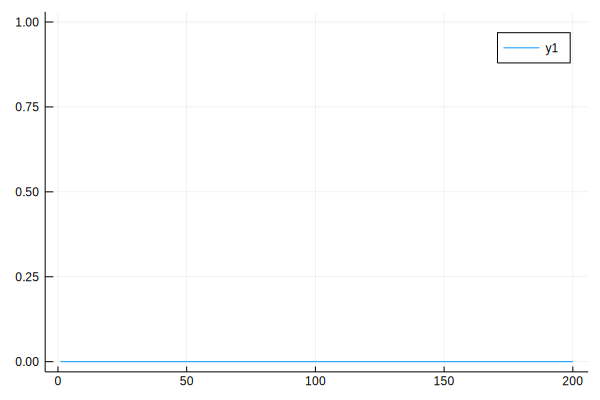

In [ ]:
# m close all; clear all; format compact;
using CSV,DataFrames,SpecialFunctions,Plots
CSV.write("_test.txt",[],writeheader=true,header=["Start"])
tic=time() # Set the signal parameters for the empirical calculation of the BER.
    Rb = 1; # Signalling rate, bits per second.
    spreading_factor = 400; # Number of carrier samples representing a single bit, that is, bit length.
    Tb = 1/Rb;  # Bit period, seconds.
    Ts = Tb/spreading_factor; # Sampling period.
    fs = 1/Ts;  # Sampling frequency.
    A = 1; # Amplitude of the sinusoidal signal.
    Eb = 0.487669253424892; #0.487668344247948; 
                # Determined over 2.65 million runs, ie. 2.65 billion samples.
    P = Eb/Tb;  # Power of the signal.
    runs_limit = 1000 #500000; 
    # Number of run times for each Eb/No ratio, that is
    # each transmitted message at a given Eb/No ratio.
    EbtoNo_dB_row = 0:1:5 #m [0:1:5]#[0:1:30]#[0:1:10, 10.5]#[0:2:10]
    points = length(EbtoNo_dB_row)  #m numel() # Number of points to be plotted on the BER curve.
    Pe=zeros(points)
for EtoNo = 1:1 #points # Start of the BER determination loop where each Eb/No is used.
    EbtoNo_dB = EbtoNo_dB_row[EtoNo] #m (EtoNo)
    EbtoNo = 10^(EbtoNo_dB/10); # dB to linear.
    No = (P*Ts*spreading_factor)/EbtoNo; # Power spectral density of noise.
    variance = (No/2)*fs; # Power of noise. Peak of the autocorrelation function: power.
    s = sqrt(variance);   # Noise amplitude.
# Set BER determination paramters to zero.
    incorrect_bits = 0;
#correct_bits = 0;
    bit_number=0;mess=0; #m julia needs to define outside loop to access 

for runs = 1:1 #runs_limit #5000
# Use the sinusoidal signal to generate the bit 1 and 0 sequences once (the orthogonal carriers).
    mess = [round(rand()) round(rand()) round(rand()) round(rand()) round(rand()) round(rand()) round(rand()) round(rand()) round(rand()) round(rand())]; 
    #m need rand() # Transmitted message.
    bit_number = length(mess); # Number of bits in the transmitted message.

begin # MODULATE the chaos based signal by the message.
    p = [0, (7.7+rand()/10), (8.5-rand()/10), (9.3+rand()/10), (10.1+rand()/10), (11.3-rand()/10)];
            # Chaotic parameters. p(1) is unused.
    fc_factor = 20; # Value 20 is used in T. Carroll's paper to produce a chaos based signal.
    pocetak = 20; # Start of the chaotic signal in generation of the chaos based signal.
    kraj = 296;   # End of the chaotic signal in generation of the chaos based signal.
end

begin # Generate the Carroll chaotic signal zeta_steady.
# Transient samples to be removed:
    transient_samples = 999;                         
# Initial conditions:
    x0_initial=zeros(6)
    x0_initial[1] = 0.23;
    x0_initial[2] = 0.1;
    x0_initial[3] = 0.17;
    x0_initial[4] = 0.3;
    x0_initial[5] = 0.5;
    x0_initial[6] = 0.41;
    zeta_initial = 0 + 0.5;
end
        
begin # Generate the first point:
    #m clear sum_r;
    r=zeros(5) #m r=zeros(1,5);
    for i = 2:6
        r[i-1] = p[i] * x0_initial[i];
    end
    sum_r = sum(r); # Get the sum.
end
            
begin # Initialize variables for program execution speed optimization:
    x1 = zeros(spreading_factor*bit_number+transient_samples);
    x2 = zeros(spreading_factor*bit_number+transient_samples);
    x3 = zeros(spreading_factor*bit_number+transient_samples);
    x4 = zeros(spreading_factor*bit_number+transient_samples);
    x5 = zeros(spreading_factor*bit_number+transient_samples);
    x6 = zeros(spreading_factor*bit_number+transient_samples);
    zeta = zeros(spreading_factor*bit_number+transient_samples);
    # Set initial conditions.
    x1[1] = mod(sum_r, 1);
    x2[1] = x0_initial[3];
    x3[1] = x0_initial[4];
    x4[1] = x0_initial[5];
    x5[1] = x0_initial[6];
    x6[1] = x0_initial[1];
    zeta[1] = x1[1] + 0.5;
end

# Generate all other points up to chaotic_points value:       
for j = 1:(spreading_factor*bit_number+transient_samples-1)
    #m clear sum_r;
    # Get the sum
    sum_r = p[2]*x2[j] + p[3]*x3[j] + p[4]*x4[j] + p[5]*x5[j] + p[6]*x6[j]; 
    x1[j+1] = mod(sum_r, 1);
    x2[j+1] = x3[j];
    x3[j+1] = x4[j];
    x4[j+1] = x5[j];
    x5[j+1] = x6[j];
    x6[j+1] = x1[j];
    zeta[j+1] = x1[j+1] + 0.5;
end

begin # Form the final signal vector:
    #println("zeta ",length(zeta_initial),",",length(zeta));display()
    zeta = [zeta_initial;zeta];
    # Form the final signal to be used by removing the first 4000 points of the
    # transient:
    #println("zeta=",zeta)
    #println("zeta from ",transient_samples+2," to ",length(zeta));display()
    zeta_steady = zeta[(transient_samples+2):length(zeta)];
end

begin # Generate the chaos based signal z and modulate it
      # by the binary message x.
    n = 0; # t in equation 4 of T.L.Carroll's paper.
    z = zeros(1,spreading_factor*bit_number#=-1=#);#m not -1 # Output signal initialized. -1 to allow entrance into while loop below.
    counter = 0; # Used for indexing output signal.
    # Generate z:
    #m clear j;
    #println("pocetak,kraj,zeta_steady,z:",pocetak,
    #        ",",kraj," ",length(zeta_steady),",",length(z));display();
    for j = pocetak:kraj # Use values from the middle of the chaotic signal.
        if (length(z) < (spreading_factor*bit_number))
            while (n < (fc_factor*zeta_steady[j]))
                counter = counter + 1;
                z[counter] = sin(2*pi*n/(fc_factor*zeta_steady[j]));
                n = n + 1;
            end
            n = 0;
        end
    end
end

begin #check average length of z signal 
    z = z[1:(spreading_factor*bit_number)];
    display(plot(z[1:200]))
    # Get the average length of the z signal, if not N stop the program.
    # If the value of kraj is too low the 'z' signal will have
    # less than spreading_factor*length(x) samples and program will be stopped.
    if length(z) != (spreading_factor*bit_number)
        println("z signal average length is not spreading_factor*bit_number,
                    its signal lengths is: ",length(z));display()
        #m disp("length(z)")
    end
end;
        
begin # Modulate the input bit sequence.
    y=zeros(length(z)) #m this added
    for n = 1:bit_number
        if mess[n] == 1
            y[((n-1)*spreading_factor+1):(n*spreading_factor)]=
                    z[((n-1)*spreading_factor+1):(n*spreading_factor)];
        elseif mess[n] == 0
            y[((n-1)*spreading_factor+1):(n*spreading_factor)]=
                    -1*z[((n-1)*spreading_factor+1):(n*spreading_factor)];
        else
            display("Input bit sequence must be composed of only 1s and 0s
                        no other values allowed, aborting program.")
        end
    end
    message = A*y;
end # End of MODULATION

begin # The AWGN CHANNEL. 
    # Generate and add noise to signal.
    noise = s*randn(bit_number*spreading_factor); # [1 2 3 4 5]
    # Get the noise polluted signal.
    transmitted_message = message + noise;
end

begin # DEMODULATION: Integrate squared received signal thus create decision variables, bit(i).
    # The demodulator also performs decoding to return the vector z containing the received bit stream.
    # Note: reference_signal = z;, ie. reference_signal = z = chaos based signal.
    # In phase correlate the reference signal z with the input signal transmitted_message and
    # threshold it to 0 to determine whether the demodulated bit is a 1 or a 0.
    received_message = zeros(bit_number); # Initialize the demodulated output bit stream vector.
    for n = 1:bit_number
        Ryr=sqrt(2*Rb)*z[((n-1)*spreading_factor+1):(n*spreading_factor)]'*
            transmitted_message[((n-1)*spreading_factor+1):(n*spreading_factor)];
                #m check production of scalar here
        if(Ryr > 0)
            d = 1;
        elseif(Ryr < 0)
            d = 0;
        else # If neither is satisfied, highly unlikely, toss a coin.
            decider = rand();
            while (decider == 0)
                decider = rand();
            end
            if (decider > 0)
                d = 1;
            else
                d = 0;
            end
        end
    received_message[n] = d;    
    end
end

# Compare the received message with the sent message and determine how many
# bits have been received (decoded) incorrectly and how many correctly.
for k = 1:bit_number  
    if (received_message[k] != mess[k])
        incorrect_bits = incorrect_bits + 1;
#     else
#         correct_bits = correct_bits + 1;
    end   
end

end # runs loop

begin
    # Determine the total number of bits.
    total_bits = runs_limit*bit_number;
    # Calculate the probability of error Pe.
    Pe[EtoNo] = incorrect_bits/total_bits
    #m save Pe_vector Pe #m why save here?
    #m save EbNo_dB_vector EbtoNo_dB_row
end

end # EtoNo loop

begin # save and plot
    toc=time()-tic
    CSV.write("_test.txt",[],append=true,writeheader=true,header=["Pe_vector"])
    CSV.write("_test.txt",DataFrame(Pe'),append=true)
    CSV.write("_test.txt",[],append=true,writeheader=true,header=["EbNo_dB_vector"])
    CSV.write("_test.txt",DataFrame(EbtoNo_dB_row'),append=true)
    CSV.write("_test.txt",[],append=true,writeheader=true,header=["total time"])
    CSV.write("_test.txt",[],append=true,writeheader=true,header=[toc])

    # Theoretical calculation of the BER (Pe).
    EbNo_dB_theory = 0:10;
    EbNo_theory=zeros(length(EbNo_dB_theory))
    BER_theory=zeros(length(EbNo_dB_theory))
    for n = 1:length(EbNo_dB_theory)
        EbNo_theory[n] = 10^(EbNo_dB_theory[n]/10);
        BER_theory[n] = 0.5*erfc(sqrt(EbNo_theory[n]));
    end
    plot(EbNo_dB_theory,BER_theory,yaxis=:log,legend=:top,label="theoretical")
    plot!(EbtoNo_dB_row,Pe,yaxis=:log,label="empirical")
end
